### Descripción del problema

Nota: Funcional. Descartamos las medidas de forest que solo tengan una direccion (up or down).  
Descartamos las medidas con errores de LAI alto.  
Descartamos las medidas con errores de clumping alto (up y down).  
Reservamos las medidas de 2023 para el test final.  
Eliminamos el outlier con id 20190918T154919_20190918T160136_T18SUJ.  
Seleccionamos las medidas insitu con una diferencia de dias menos de 5 dias con respecto a las adquisiciones del satelite.

### Variables y librerías

Definimos variables importantes:

In [229]:
file_name_sat = 'S2_SR_USA_2017_2024_SCL.csv'
file_name_insitu = 'NEON_LAI_USA_2017_2024.csv'

Importamos las librerías

In [230]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

import os

from sklearn import metrics

from variables import COORDS as coords

In [231]:
# Montamos nuestro Google Drive si usamos entorno de Colab
#from google.colab import drive
#drive.mount('/content/drive')

### 1. Datos de satelite

#### Cargamos el dataset de datos de satelite

Para entorno de **Google Colab**

In [232]:
#drive_path = '/content/drive/MyDrive/Colab Notebooks/'
#!ls /content/drive/MyDrive/Colab\ Notebooks/
#dataset_path = drive_path + file_name_sat

Para entorno **local**

In [233]:
# Definimos ruta de los archivos.
datadir_path = os.path.join('..','data')
dataset_path = os.path.join(datadir_path, file_name_sat)

**Importamos el dataset** con Pandas y visualizamos las primeras instancias

In [234]:
df_sat = pd.read_csv(dataset_path, sep=',')

# Eliminamos columna innecesaria de indices importado
if 'Unnamed: 0' in df_sat.columns: # Comprobamos si 'Unnamed: 0' está en las columnas
    # Eliminar la columna 'Unnamed: 0'
    df_sat.drop(columns=['Unnamed: 0'], inplace=True) 
df_sat.head(5)

,id,longitude,latitude,time,B1,B2,B3,B4,B5,B6,...,B8,B8A,B9,B11,B12,SCL,QA10,QA20,QA60,Site_sat
0,20171222T182749_20171222T183128_T12TUK,-112.452455,40.177600,1513967574868,3597.0,3704.0,3788.0,3972.0,4316.0,4280.0,...,4272.0,4349.0,4724.0,1167.0,1091.0,11.0,NaN,NaN,0,Onaqui Ault
1,20171118T170559_20171118T170554_T15TYL,-89.586378,45.508922,1511025045890,8393.0,8072.0,7776.0,7568.0,7652.0,7527.0,...,7632.0,7314.0,10924.0,2087.0,2396.0,8.0,NaN,NaN,1024,Steigerwaldt Land Services
2,20171225T165709_20171225T165708_T15TYL,-89.586378,45.508922,1514221250709,3381.0,3469.0,3256.0,3317.0,3473.0,3863.0,...,4376.0,4062.0,3881.0,2315.0,1911.0,9.0,NaN,NaN,2048,Steigerwaldt Land Services
3,20171118T170559_20171118T170554_T15SUD,-95.192225,39.040513,1511025161923,7635.0,7848.0,7632.0,7480.0,7621.0,7438.0,...,7944.0,7295.0,10781.0,1901.0,2098.0,8.0,NaN,NaN,1024,University of Kansas Field Site
4,20171118T170559_20171118T170554_T15TYM,-89.537510,46.234042,1511025031342,5584.0,5352.0,5124.0,5016.0,5094.0,5038.0,...,4980.0,4760.0,6066.0,3001.0,2600.0,9.0,NaN,NaN,1024,Underc


In [235]:
df_sat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22975 entries, 0 to 22974
Data columns (total 21 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         22975 non-null  object 
 1   longitude  22975 non-null  float64
 2   latitude   22975 non-null  float64
 3   time       22975 non-null  int64  
 4   B1         22949 non-null  float64
 5   B2         22959 non-null  float64
 6   B3         22960 non-null  float64
 7   B4         22960 non-null  float64
 8   B5         22960 non-null  float64
 9   B6         22960 non-null  float64
 10  B7         22960 non-null  float64
 11  B8         22960 non-null  float64
 12  B8A        22960 non-null  float64
 13  B9         22963 non-null  float64
 14  B11        22960 non-null  float64
 15  B12        22960 non-null  float64
 16  SCL        22960 non-null  float64
 17  QA10       16075 non-null  float64
 18  QA20       16075 non-null  float64
 19  QA60       22975 non-null  int64  
 20  Site_s

#### Limpiamos y procesamos el dataset

Convertimos a tipo **datetime** la columna 'time' que está en formato Unix epoch time.

In [236]:
#df_sat['time'] = df_sat['time'].apply(lambda x: dt.datetime.utcfromtimestamp(x / 1000))
df_sat['time'] = pd.to_datetime(df_sat['time'], unit='ms')

**Ordenamos** el dataframe por Site y time, y **reseteamos** el indice.

In [237]:
df_sat.sort_values(by=['Site_sat','time'], inplace=True)
df_sat.reset_index(drop=True, inplace=True)

**Eliminamos columnas innecesarias.**  
QA10 y QA20 son columnas vacias.  
También descartamos las bandas de 60m que corresponden a aerosoles y vapor de agua: B1 y B9

In [238]:
df_sat.drop(columns=['B1', 'B9', 'QA10', 'QA20'], inplace=True)

**Eliminamos las filas** (espectros) correspondientes a **pixeles con nubes**  
Los pixes con nubes corresponden a: QA60 == 512 or QA60 == 1024 or QA60 == 2048  
Por lo tanto nos quedamos solo con los pixeles libres de nubes: QA60 == 0

In [239]:
len(df_sat) # Antes de eliminar filas vemos el tamaño del dataset

22975

In [240]:
df_sat['QA60'].value_counts() # También vemos la cantidad de pixeles con nubes

QA60
0       15915
1024     5244
2048     1816
Name: count, dtype: int64

In [241]:
df_sat = df_sat[df_sat['QA60'] == 0] # Me quedo con las filas (pixeles) libre de nubes

In [242]:
len(df_sat) # Vemos como queda el tamaño del dataset luego de eliminar pixeles con nubes

15915

**Elimino filas de no-vegetación**  
Me quedo con las filas (pixeles) de vegetación según la banda 'SCL' de Sentinel-2.  
Zonas de vegetación pueden estar cubiertas de nieve en alguna epoca del año.  
Por lo tanto, eliminamos esos pixeles.

In [243]:
len(df_sat) # Antes de eliminar filas vemos el tamaño del dataset

15915

In [244]:
df_sat = df_sat[df_sat['SCL'] == 4] # Me quedo con las filas (pixeles) de vegetación

In [245]:
len(df_sat) # Vemos como queda el tamaño del dataset luego de eliminar pixeles

5547

**Escalamos las bandas** a los valores de reflectancia reales (originalmente están multiplicados por 10000).

In [246]:
bandas = ['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12'] # Definimos una lista con las columnas correspondientes a las bandas

In [247]:
for banda in bandas: # Recorremos todas las bandas
    df_sat.loc[:,banda] = df_sat[banda].astype(float) # Forzamos el tipo de los datos para hacerlos float.
    df_sat.loc[:,banda] = df_sat[banda] * 0.0001 # Escalamos

In [248]:
# Vemos como queda nuestro dataset
df_sat.head()

,id,longitude,latitude,time,B2,B3,B4,B5,B6,B7,B8,B8A,B11,B12,SCL,QA60,Site_sat
23,20190128T154519_20190128T154758_T19TCJ,-71.287337,44.063892,2019-01-28 15:50:57.000,0.0543,0.0520,0.0584,0.0665,0.1536,0.1727,0.2460,0.2054,0.0793,0.0550,4.0,0,Bartlett Experimental Forest
24,20190128T154519_20190128T154758_T18TYP,-71.287337,44.063892,2019-01-28 15:51:01.000,0.0251,0.0346,0.0358,0.0649,0.1531,0.1739,0.2365,0.2108,0.0815,0.0570,4.0,0,Bartlett Experimental Forest
33,20190222T154241_20190222T154730_T19TCJ,-71.287337,44.063892,2019-02-22 15:50:52.000,0.0642,0.0854,0.0816,0.0890,0.1784,0.2129,0.2199,0.2268,0.1014,0.0616,4.0,0,Bartlett Experimental Forest
34,20190222T154241_20190222T154730_T18TYP,-71.287337,44.063892,2019-02-22 15:50:56.000,0.0438,0.0541,0.0619,0.0842,0.1787,0.2139,0.1845,0.2290,0.1034,0.0623,4.0,0,Bartlett Experimental Forest
63,20190508T153819_20190508T154933_T19TCJ,-71.287337,44.063892,2019-05-08 15:51:05.057,0.0388,0.0560,0.0564,0.0942,0.1683,0.1943,0.2432,0.2120,0.1615,0.0985,4.0,0,Bartlett Experimental Forest


#### Visualización y exploración

Visualizamos muestras de los espectros de vegetación en un gráfico

In [249]:
# Definimos la longitud de onda central de las bandas
central_wl = {
    'B2': 490,  # Banda 2 (Azul)
    'B3': 560,  # Banda 3 (Verde)
    'B4': 665,  # Banda 4 (Rojo)
    'B5': 705,  # Banda 5
    'B6': 740,  # Banda 6
    'B7': 783,  # Banda 7
    'B8': 842,  # Banda 8 (Infrarrojo cercano)
    'B8A': 865, # Banda 8A
    'B11': 1610, # Banda 11 (Infrarrojo de onda corta)
    'B12': 2190  # Banda 12
}

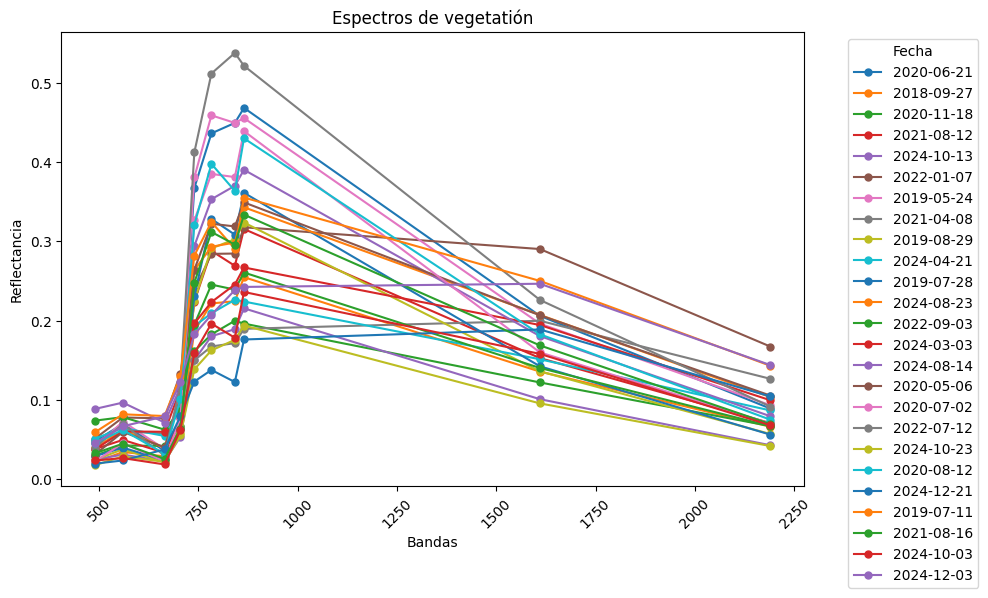

In [250]:
# Graficar diferentes espectros
plt.figure(figsize=(10, 6))  # Definir tamaño de la figura

for index, row in df_sat.sample(25).iterrows():
    plt.plot([central_wl[band] for band in bandas], row[bandas], label=row['time'].strftime('%Y-%m-%d'), marker='o', linestyle='-', markersize=5)

# Configuración del gráfico
plt.title("Espectros de vegetatión")
plt.xlabel("Bandas")
plt.ylabel("Reflectancia")
plt.legend(title="Fecha", bbox_to_anchor=(1.05, 1), loc='upper left')  # Mueve la leyenda fuera de la gráfica

# Mostrar gráfico
plt.xticks(rotation=45)  # Rotar las etiquetas de las bandas
plt.tight_layout()  # Ajustar el espacio
plt.show();

Calculamos el NDVI y graficamos series temporales de muestras de pixeles para verificar que se aproxima a la realidad

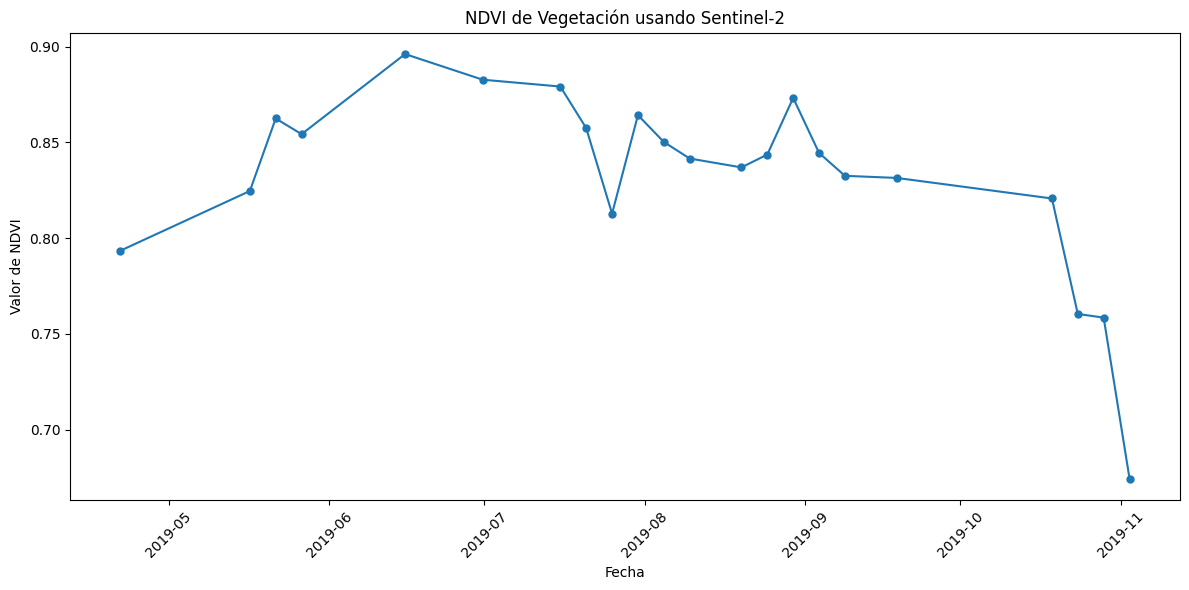

In [251]:
# Calcular NDVI para cada espectro (fila) del DataFrame
df_VI = df_sat.copy()
df_VI['NDVI'] = (df_VI['B8'] - df_VI['B4']) / (df_VI['B8'] + df_VI['B4'])

# Graficar el NDVI para el site y el año seleccionado
plt.figure(figsize=(12, 6))
mask_Lajas_2019 = (df_VI['Site_sat'] == 'Smithsonian Environmental Research Center') & (df_VI['time'].dt.year == 2019)
plt.plot(df_VI.loc[mask_Lajas_2019,'time'], df_VI.loc[mask_Lajas_2019,'NDVI'], marker='o', linestyle='-', markersize=5)

# Configuración del gráfico
plt.title("NDVI de Vegetación usando Sentinel-2")
plt.xlabel("Fecha")
plt.ylabel("Valor de NDVI")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Image of vegetation phenology

![Image of vegetation phenology](https://www.scielo.org.mx/img/revistas/tl/v36n4//2395-8030-tl-36-04-393-gf1.png)

### 2. Datos de campo

#### Cargamos el dataset de medidas insitu

Para entorno de **Google Colab**

In [252]:
#drive_path = '/content/drive/MyDrive/Colab Notebooks/'
#!ls /content/drive/MyDrive/Colab\ Notebooks/
#dataset_path_insitu = drive_path + file_name_insitu

Para entorno **local**

In [253]:
# Definimos ruta de los archivos.
#datadir_path = os.path.join('..','data')
dataset_path_insitu = os.path.join(datadir_path, file_name_insitu)

**Importamos el dataset** con Pandas y visualizamos las primeras instancias

In [254]:
df_insitu = pd.read_csv(dataset_path_insitu, sep=',')

# Eliminamos columna innecesaria de indices importado
if 'Unnamed: 0' in df_insitu.columns: # Comprobamos si 'Unnamed: 0' está en las columnas
    # Eliminar la columna 'Unnamed: 0'
    df_insitu.drop(columns=['Unnamed: 0'], inplace=True) 
df_sat.head(5)

,id,longitude,latitude,time,B2,B3,B4,B5,B6,B7,B8,B8A,B11,B12,SCL,QA60,Site_sat
23,20190128T154519_20190128T154758_T19TCJ,-71.287337,44.063892,2019-01-28 15:50:57.000,0.0543,0.0520,0.0584,0.0665,0.1536,0.1727,0.2460,0.2054,0.0793,0.0550,4.0,0,Bartlett Experimental Forest
24,20190128T154519_20190128T154758_T18TYP,-71.287337,44.063892,2019-01-28 15:51:01.000,0.0251,0.0346,0.0358,0.0649,0.1531,0.1739,0.2365,0.2108,0.0815,0.0570,4.0,0,Bartlett Experimental Forest
33,20190222T154241_20190222T154730_T19TCJ,-71.287337,44.063892,2019-02-22 15:50:52.000,0.0642,0.0854,0.0816,0.0890,0.1784,0.2129,0.2199,0.2268,0.1014,0.0616,4.0,0,Bartlett Experimental Forest
34,20190222T154241_20190222T154730_T18TYP,-71.287337,44.063892,2019-02-22 15:50:56.000,0.0438,0.0541,0.0619,0.0842,0.1787,0.2139,0.1845,0.2290,0.1034,0.0623,4.0,0,Bartlett Experimental Forest
63,20190508T153819_20190508T154933_T19TCJ,-71.287337,44.063892,2019-05-08 15:51:05.057,0.0388,0.0560,0.0564,0.0942,0.1683,0.1943,0.2432,0.2120,0.1615,0.0985,4.0,0,Bartlett Experimental Forest


In [255]:
df_insitu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9406 entries, 0 to 9405
Data columns (total 38 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   GBOV_ID                   9406 non-null   object 
 1   Site                      9406 non-null   object 
 2   GROUND_DATA_PI            9176 non-null   object 
 3   GROUND_DATA_PIs_Email     9176 non-null   object 
 4   GBOV_Email                9406 non-null   object 
 5   Network                   9406 non-null   object 
 6   Elevation                 9406 non-null   int64  
 7   IGBP_class                9406 non-null   object 
 8   Lat_IS                    9406 non-null   float64
 9   Lon_IS                    9406 non-null   float64
 10  TIME_IS                   9406 non-null   object 
 11  Version                   9406 non-null   float64
 12  up_flag                   7713 non-null   float64
 13  down_flag                 7713 non-null   float64
 14  LAI_Mill

#### Limpiamos y procesamos el dataset

Convertimos a tipo **datetime** la columna 'TIME_IS'

In [256]:
df_insitu['TIME_IS'] = pd.to_datetime(df_insitu['TIME_IS'])

Pasamos todos los valores **nulos** a NaN

In [257]:
valores_nulos = [-999.0, 999.0, -999, 999, '-999.0', '999.0', '-999', '999'] # Lista de valores a reemplazar por NaN
df_insitu.replace(valores_nulos, np.nan, inplace=True) # Reemplazar todos los valores por NaN
len(df_insitu)

9406

**Eliminamos filas** fijandonos en las columnas del **quality flag**

In [258]:
# Nos quedamos con valores de up_flag = 0, que son los de mejor calidad, los demás los marcamos como nulos
mask_invalid_up = df_insitu['up_flag'] != 0
df_insitu.loc[mask_invalid_up,'up_flag'] = np.nan

# Lo mismo para down_flag
mask_invalid_down = df_insitu['down_flag'] != 0
df_insitu.loc[mask_invalid_down,'down_flag'] = np.nan

# Eliminamos filas donde ambas flags son nulas
df_insitu.dropna(subset=['up_flag','down_flag'], how='all', inplace=True)
len(df_insitu)

7486

Definimos las **columnas numéricas**

In [259]:
col_numericas = [
 'LAI_Miller_up',
 'LAI_Warren_up',
 'LAIe_Miller_up',
 'LAIe_Warren_up',
 'LAI_Miller_down',
 'LAI_Warren_down',
 'LAIe_Miller_down',
 'LAIe_Warren_down',
 'LAI_Miller_up_err',
 'LAI_Warren_up_err',
 'LAIe_Miller_up_err',
 'LAIe_Warren_up_err',
 'clumping_Miller_up',
 'clumping_Warren_up',
 'LAI_Miller_down_err',
 'LAI_Warren_down_err',
 'LAIe_Miller_down_err',
 'LAIe_Warren_down_err',
 'clumping_Miller_down',
 'clumping_Warren_down',
 'clumping_Miller_up_err',
 'clumping_Warren_up_err',
 'clumping_Miller_down_err',
 'clumping_Warren_down_err']

Miramos si existen **caracteres no numericos** en las columnas que impidan convertirlas a float.

In [260]:
for col in col_numericas:
    # print('\n',col)
    for valor in df_insitu[col]:
        try:
            # Intentar convertir a float, si falla significa que el valor no es numérico
            valor = str(valor)
            float(valor)  # Intentar convertir a float
        except ValueError:
            # Si no se puede convertir, es un valor no numérico
            print(valor)


(7.2
(7.9
(8.0
(8.0
(8
(9
(7.2
(7.9
(8.0
(8.0
(8
(9
1.0)e-05
1.7)e-05
1.7)e-05
1.9)e-05
4)e-05
5)e-05
1.0)e-05
1.7)e-05
1.7)e-05
1.9)e-05
4)e-05
5)e-05


Removemos caracteres no numericos y **forzamos el tipo de datos**

In [261]:
for col in col_numericas:
    if df_insitu[col].dtypes != 'float':
        #print(col)
        # Limpiamos las columnas numericas de caracteres indeseados.
        df_insitu[col] = df_insitu[col].str.strip().str.replace('(', '').str.replace('(', '').str.replace(')', '')  # .str.replace("[^0-9.e]", '', regex=True)
        #df_insitu[col].astype(float, errors='ignore')
        df_insitu[col] =  pd.to_numeric(df_insitu[col],errors='coerce')


Visualizamos las diferentes clases de cubierta según 'IGBP_class'.  
Definimos las clases que forman parte de forest. 

In [262]:
df_insitu['IGBP_class'].unique()

array(['Mixed Forest', 'Evergreen Needleleaf', 'Open Shrublands',
       'Croplands', 'Grasslands', 'Deciduous Broadleaf Forest',
       'Evergreen Broadleaf', 'Evergreen Needleleaf Forest',
       'Closed Shrublands', 'Deciduous Broadleaf'], dtype=object)

In [263]:
class_forest = ['Mixed Forest', 'Evergreen Needleleaf', 'Deciduous Broadleaf Forest', 'Evergreen Broadleaf', 'Evergreen Needleleaf Forest','Deciduous Broadleaf']

Definimos las **quality flags** especificas para las medidas del método Warren ('Warren_up_flag','Warren_down_flag').  
Nos basamos en las quality flags generales ('up_flag' y 'down_flag').

In [264]:
df_insitu.loc[df_insitu['LAI_Warren_up'].notnull() & df_insitu['LAI_Warren_down'].notnull() & (df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0), ['Warren_up_flag','Warren_down_flag']] = 0

df_insitu.loc[df_insitu['LAI_Warren_up'].notnull() & df_insitu['LAI_Warren_down'].isnull() & (df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0), 'Warren_down_flag'] = np.nan
df_insitu.loc[df_insitu['LAI_Warren_up'].notnull() & df_insitu['LAI_Warren_down'].isnull() & (df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0), 'Warren_up_flag'] = 0

df_insitu.loc[df_insitu['LAI_Warren_up'].isnull() & df_insitu['LAI_Warren_down'].notnull() & (df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0), 'Warren_up_flag'] = np.nan
df_insitu.loc[df_insitu['LAI_Warren_up'].isnull() & df_insitu['LAI_Warren_down'].notnull() & (df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0), 'Warren_down_flag'] = 0


df_insitu.loc[(df_insitu['up_flag'] == 0) & df_insitu['down_flag'].isnull(), 'Warren_down_flag'] = np.nan
df_insitu.loc[df_insitu['LAI_Warren_up'].notnull() & (df_insitu['up_flag'] == 0) & df_insitu['down_flag'].isnull(), 'Warren_up_flag'] = 0

df_insitu.loc[df_insitu['up_flag'].isnull() & (df_insitu['down_flag'] == 0), 'Warren_up_flag'] = np.nan
df_insitu.loc[df_insitu['LAI_Warren_down'].notnull() & df_insitu['up_flag'].isnull() & df_insitu['down_flag'] == 0, 'Warren_down_flag'] = 0

**Calculamos el LAI y su error** en base a las quality flags.  
**Nota:** Nos quedamos con el LAI de las clases forest solo cuando tiene ambas medidas (LAI up y LAI down).

In [265]:
df_insitu.loc[(df_insitu['Warren_up_flag'] == 0) & (df_insitu['Warren_down_flag'] == 0), 'LAI_Warren'] = df_insitu['LAI_Warren_up'] + df_insitu['LAI_Warren_down']
df_insitu.loc[(df_insitu['Warren_up_flag'] == 0) & (df_insitu['Warren_down_flag'] == 0), 'LAI_Warren_err'] = df_insitu['LAI_Warren_up_err'] + df_insitu['LAI_Warren_down_err'] 


df_insitu.loc[(df_insitu['Warren_up_flag'] == 0) & df_insitu['Warren_down_flag'].isnull() & (df_insitu['IGBP_class'].isin(class_forest)), 'LAI_Warren'] = np.nan # Descartamos las medidas de forest cuando son solo upwards
df_insitu.loc[(df_insitu['Warren_up_flag'] == 0) & df_insitu['Warren_down_flag'].isnull() & (~df_insitu['IGBP_class'].isin(class_forest)), 'LAI_Warren'] = df_insitu['LAI_Warren_up']
df_insitu.loc[(df_insitu['Warren_up_flag'] == 0) & df_insitu['Warren_down_flag'].isnull() & (~df_insitu['IGBP_class'].isin(class_forest)), 'LAI_Warren_err'] = df_insitu['LAI_Warren_up_err']


df_insitu.loc[df_insitu['Warren_up_flag'].isnull() & (df_insitu['Warren_down_flag'] == 0) & (df_insitu['IGBP_class'].isin(class_forest)), 'LAI_Warren'] = np.nan # Descartamos las medidas de forest cuando son solo downwards
df_insitu.loc[df_insitu['Warren_up_flag'].isnull() & (df_insitu['Warren_down_flag'] == 0) & (~df_insitu['IGBP_class'].isin(class_forest)), 'LAI_Warren'] = df_insitu['LAI_Warren_down']
df_insitu.loc[df_insitu['Warren_up_flag'].isnull() & (df_insitu['Warren_down_flag'] == 0) & (~df_insitu['IGBP_class'].isin(class_forest)), 'LAI_Warren_err'] = df_insitu['LAI_Warren_down_err']


print(df_insitu['LAI_Warren'].isna().sum())

721


Eliminamos filas con **errores** más altos de LAI y de clumpling.

In [266]:
# Descartamos medidas con errores mas altos
df_insitu = df_insitu[df_insitu['LAI_Warren_err'] <= 0.45]
df_insitu.loc[df_insitu['clumping_Warren_up_err'] >= 0.1,'LAI_Warren'] = np.nan
df_insitu.loc[df_insitu['clumping_Warren_down_err'] >= 0.35, 'LAI_Warren'] = np.nan

In [267]:
# Eliminamos las filas donde el LAI es nulo
df_insitu.dropna(subset=['LAI_Warren'], inplace=True)
len(df_insitu)

5850

Visualizamos la **información** del dataset para  ver como queda.

In [268]:
df_insitu.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5850 entries, 0 to 9404
Data columns (total 42 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   GBOV_ID                   5850 non-null   object             
 1   Site                      5850 non-null   object             
 2   GROUND_DATA_PI            5768 non-null   object             
 3   GROUND_DATA_PIs_Email     5768 non-null   object             
 4   GBOV_Email                5850 non-null   object             
 5   Network                   5850 non-null   object             
 6   Elevation                 5850 non-null   int64              
 7   IGBP_class                5850 non-null   object             
 8   Lat_IS                    5850 non-null   float64            
 9   Lon_IS                    5850 non-null   float64            
 10  TIME_IS                   5850 non-null   datetime64[ns, UTC]
 11  Version               

### 3. Combinación de los datasets

Quitamos el **dato UTC** a la columna fecha para estandarizarla con el dataset de satelite.

In [269]:
df_insitu[['Site','TIME_IS']].head(2)

,Site,TIME_IS
0,Harvard Forest,2018-08-13 00:00:00+00:00
2,Harvard Forest,2018-08-13 00:00:00+00:00


In [270]:
df_insitu['TIME_IS'] = pd.to_datetime(df_insitu['TIME_IS']).dt.tz_localize(None)
df_insitu[['Site','TIME_IS']].head(2)

,Site,TIME_IS
0,Harvard Forest,2018-08-13
2,Harvard Forest,2018-08-13


**Merge de data sets**. Para cada site identificamos las medidas in_situ mas cercanas a la fecha de adquisicion del satélite

In [271]:
df_list = []
days_diff_max = 5 # Diferencia maxima (en días) entre la medida de satelite y la medida in situ

# Itera sobre cada coordenada
for site, lat, lon in coords:
    # Filtra el DataFrame de df_insitu y df_sat según el 'Site'
    df_insitu_site = df_insitu[df_insitu['Site'] == site]
    df_sat_site = df_sat[df_sat['Site_sat'] == site]

    rows = []

    # Itera sobre los datos de satélite y sobre los datos in situ
    for index_sat, date_sat in df_sat_site['time'].items():
        for index_insitu, date_insitu in df_insitu_site['TIME_IS'].items():
            # Calcula la diferencia en días entre las fechas
            dif = (date_insitu - date_sat) / np.timedelta64(1, 'D')

            if abs(dif) <= days_diff_max: # Si la diferencia en dias es menor...
                # Crea una lista con la fila combinada de ambas fuentes de datos
                row = list(df_sat_site.loc[index_sat]) + list(df_insitu_site.loc[index_insitu])
                rows.append(row)

    # Si se encontraron filas, procesa los datos
    if rows:
        # Crear el DataFrame con las filas acumuladas
        df_cross_site = pd.DataFrame(rows, columns=list(df_sat_site.columns) + list(df_insitu_site.columns))

        # Añadir una columna 'delta' con la diferencia en tiempo entre el satélite y las mediciones in situ
        df_cross_site['delta'] = abs(df_cross_site['time'] - df_cross_site['TIME_IS'])

        # Añadir las fechas separadas de 'date_sat' y 'date_insitu'
        df_cross_site['date_sat'] = df_cross_site['time'].dt.date
        df_cross_site['date_insitu'] = df_cross_site['TIME_IS'].dt.date

        # Ordenar y eliminar duplicados por 'date_insitu'
        df_cross_site = df_cross_site.sort_values(by=['date_insitu', 'delta']).drop_duplicates(subset='date_insitu', keep='first')

        # Ordenar y eliminar duplicados por 'date_sat'
        df_cross_site = df_cross_site.sort_values(by=['date_sat', 'delta']).drop_duplicates(subset='date_sat', keep='first')


        # Agregar el DataFrame de este sitio a la lista
        df_list.append(df_cross_site)

# Combinar todos los DataFrames en uno solo
df_cross = pd.concat(df_list, axis=0, ignore_index=True)


Vemos el resultado del dataset combinado (solo algunas columnas)

In [272]:
#df_cross = df_cross.sort_values(by = ['Site','time']).reset_index(drop=True) # Reordenamos por Site y time del satelite
df_cross[['Site','date_sat','date_insitu','delta']]

,Site,date_sat,date_insitu,delta
0,Harvard Forest,2019-06-07,2019-06-04,3 days 10:17:23
1,Harvard Forest,2019-06-27,2019-07-02,4 days 13:44:37
2,Harvard Forest,2019-07-12,2019-07-16,3 days 13:53:39.569000
3,Harvard Forest,2019-08-01,2019-07-30,2 days 09:45:19.875000
4,Harvard Forest,2019-08-26,2019-08-27,0 days 14:23:40.257000
...,...,...,...,...
828,Disney Wilderness Preserve,2023-08-11,2023-08-08,3 days 04:05:34.663000
829,Disney Wilderness Preserve,2023-08-21,2023-08-22,0 days 18:58:26.181000
830,Disney Wilderness Preserve,2023-09-20,2023-09-18,2 days 01:48:32.699000
831,Disney Wilderness Preserve,2023-10-05,2023-10-03,2 days 00:55:30.152000


In [273]:
df_cross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 833 entries, 0 to 832
Data columns (total 62 columns):
 #   Column                    Non-Null Count  Dtype          
---  ------                    --------------  -----          
 0   id                        833 non-null    object         
 1   longitude                 833 non-null    float64        
 2   latitude                  833 non-null    float64        
 3   time                      833 non-null    datetime64[ns] 
 4   B2                        833 non-null    float64        
 5   B3                        833 non-null    float64        
 6   B4                        833 non-null    float64        
 7   B5                        833 non-null    float64        
 8   B6                        833 non-null    float64        
 9   B7                        833 non-null    float64        
 10  B8                        833 non-null    float64        
 11  B8A                       833 non-null    float64        
 12  B11     

Graficamos espectros de vegetación correspondientes a diferentes valores de LAI

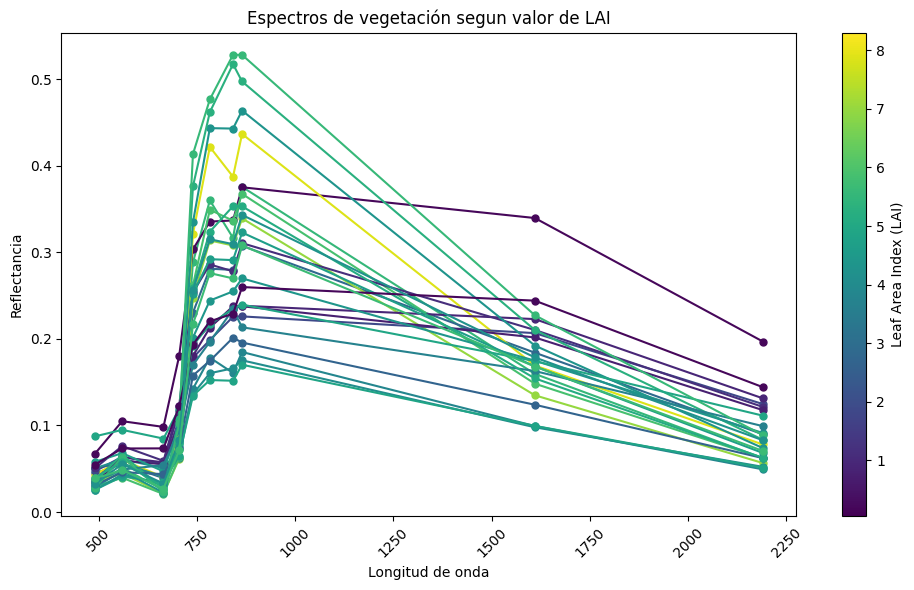

In [274]:
# Graficar diferentes espectros
fig, ax = plt.subplots(figsize=(10, 6))

# Crear una lista de colores basada en el valor de LAI
cmap = plt.get_cmap('viridis')  # Elegir un mapa de colores
norm = plt.Normalize(df_cross['LAI_Warren'].min(), df_cross['LAI_Warren'].max())  # Normalizar el rango del LAI

for index, row in df_cross.sample(25).iterrows():
    # Obtener el valor del LAI para esta fila
    lai_value = row['LAI_Warren']

    # Mapear el valor de LAI a un color
    color = cmap(norm(lai_value))  # Obtener el color correspondiente al LAI

    # Graficar el espectro, usando el valor del LAI como color de la línea
    ax.plot([central_wl[band] for band in bandas], row[bandas], label=row['date_sat'].strftime('%Y-%m-%d'),
             marker='o', linestyle='-', markersize=5, color=color)

# Añadir barra de colores para mostrar la escala del LAI
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Necesario para la barra de colores
fig.colorbar(sm, ax=ax, label='Leaf Area Index (LAI)') # Associate colorbar with the axes

# Configuración del gráfico
ax.set_title("Espectros de vegetación segun valor de LAI") # Use ax.set_title instead of plt.title
ax.set_xlabel("Longitud de onda") # Use ax.set_xlabel instead of plt.xlabel
ax.set_ylabel("Reflectancia") # Use ax.set_ylabel instead of plt.ylabel

# Mostrar gráfico
plt.xticks(rotation=45)  # Rotar las etiquetas de las bandas
plt.tight_layout()  # Ajustar el espacio
plt.show()

Exportamos el dataframe a un archivo csv (opcional).

In [275]:
#df_cross.to_csv(drive_path + 'Sentinel2_SR_NEON_USA_LAI_2017_2023.csv')

### 4. Mini EDA

Dividimos en train y test

In [276]:
df_cross = df_cross[pd.to_datetime(df_cross['date_insitu']) < pd.to_datetime('2023-01-01')]

In [277]:
df_cross = df_cross[~(df_cross['id'] == '20190918T154919_20190918T160136_T18SUJ')]

Definimos variables a excluir

In [278]:
features_sel = ['Site',
 'Lat_IS',
 'Lon_IS',
 'date_sat',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B8',
 'B8A',
 'B11',
 'B12',
 'NDVI',
 'Network',
 'Elevation',
 'IGBP_class',
 'date_insitu',
 'delta',
 'LAIe_Miller',
 'LAIe_Miller_err']

In [279]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df_cross, test_size=0.2, stratify=df_cross['IGBP_class'] ,random_state=42)
print(len(train_set))
print(len(test_set))

583
146


Definimos el target y las features

In [280]:
target = 'LAI_Warren'

In [281]:
features = bandas
features

['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']

Definimos X_train, y_train

In [282]:
X_train = train_set[features]
y_train = train_set[target]

X_test = test_set[features]
y_test = test_set[target]

Vemos la distribución de la variable objetivo.
Lamentablemente no tiene una distribución gausiana, lo que puede afectar ala algunos modelos como el de correlacion lineal.

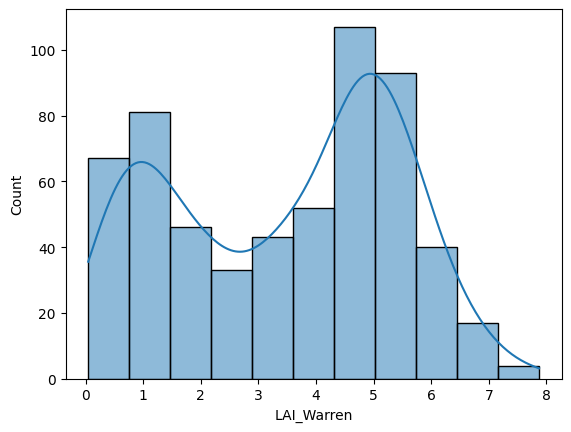

In [283]:
sns.histplot(x= target, data = train_set, kde = True);

Vemos las features (bandas) mas correlacionadas con el target

In [284]:
corr = train_set[features + [target]].corr()
np.abs(corr[target].sort_values(ascending = False))

LAI_Warren    1.000000
B7            0.283081
B8            0.271027
B8A           0.261547
B6            0.212694
B2            0.357671
B3            0.416762
B5            0.530672
B11           0.612915
B4            0.618270
B12           0.713345
Name: LAI_Warren, dtype: float64

<Axes: >

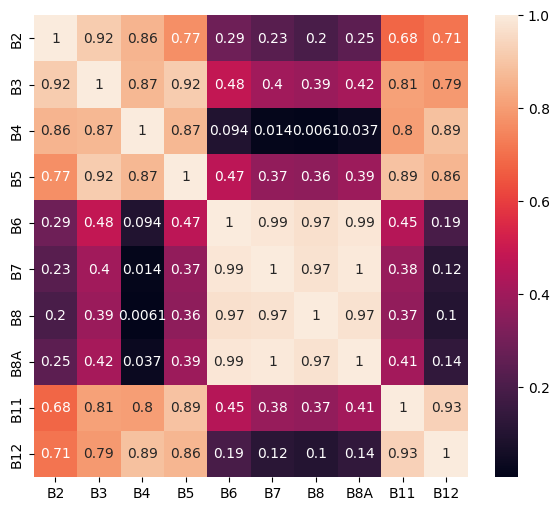

In [285]:
corr = train_set[features].corr()

plt.figure(figsize=(7,6))
sns.heatmap(abs(corr), annot=True)

<Axes: >

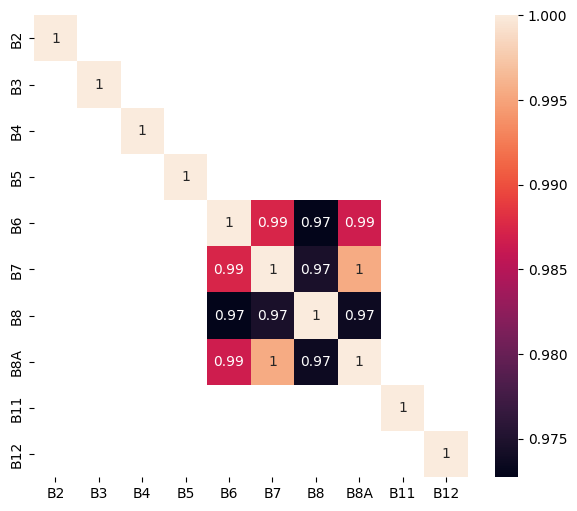

In [286]:
high_corr = corr[abs(corr) > 0.95]
plt.figure(figsize=(7,6))
sns.heatmap(abs(high_corr), annot=True)

La más alta correlación entre bandas es:  
B7-B8A del 100%.  
B6-B7 del 99%.  
B6-B8A del 99%.  
B7-B8 del 98%.  
B6-B8 del 97%.  
B8-B8A del 97%.


Descarto B8A y B6 que tienen una correlacion casi total con B7 que es la variable mas determinante en el target.

In [287]:
bandas_eliminar = ['B6','B8A']
bandas_sel = [banda for banda in bandas if banda not in bandas_eliminar]
bandas_sel

['B2', 'B3', 'B4', 'B5', 'B7', 'B8', 'B11', 'B12']

In [288]:
#features = bandas_sel
#bandas = bandas_sel

### Feature selecction

In [289]:
from sklearn.ensemble import RandomForestRegressor

X = X_train[features]
Y = y_train

rf = RandomForestRegressor(n_estimators = 100)
rf.fit(X, Y)

names = X.columns
scores = sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True)
pd.DataFrame(scores, columns=['Score', 'Feature'])

,Score,Feature
0,0.6070,B12
1,0.0810,B8A
2,0.0673,B11
3,0.0488,B2
4,0.0487,B7
5,0.0339,B5
6,0.0320,B3
7,0.0297,B4
8,0.0283,B6
9,0.0234,B8


Vemos los outliers

In [290]:
'''import seaborn as sns

# Graficar boxplot para detectar outliers en las bandas seleccionadas
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[bandas])
plt.title("Detección de outliers en las bandas de Sentinel-2")
plt.xticks(rotation=45)
plt.show()'''

'import seaborn as sns\n\n# Graficar boxplot para detectar outliers en las bandas seleccionadas\nplt.figure(figsize=(12, 6))\nsns.boxplot(data=df[bandas])\nplt.title("Detección de outliers en las bandas de Sentinel-2")\nplt.xticks(rotation=45)\nplt.show()'

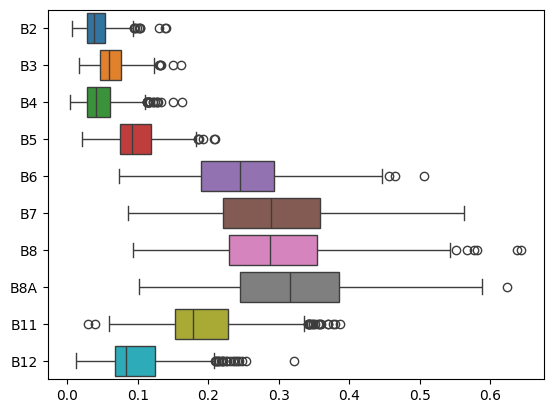

In [291]:
sns.boxplot(data = train_set[bandas], orient = "h");

### Preparacion de features

In [292]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[bandas]), columns=bandas)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[bandas]), columns=bandas)

### Construccion de modelo base

#### Linear regression

In [293]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled,y_train)


LinearRegression()

Para train

In [294]:
y_pred = lin_reg.predict(X_train_scaled)

In [295]:
argumentos = (y_train, y_pred)

print('MSE:', metrics.mean_squared_error(*argumentos))
print('RMSE:', np.sqrt(metrics.mean_squared_error(*argumentos)))
print('MAE:', metrics.mean_absolute_error(*argumentos))
print('MAPE:', metrics.mean_absolute_percentage_error(*argumentos))
print('R2:', lin_reg.score(X_train_scaled, y_train))

MSE: 1.0894164413638543
RMSE: 1.0437511395748769
MAE: 0.8301017791452566
MAPE: 0.7126807338303316
R2: 0.7225197650652189


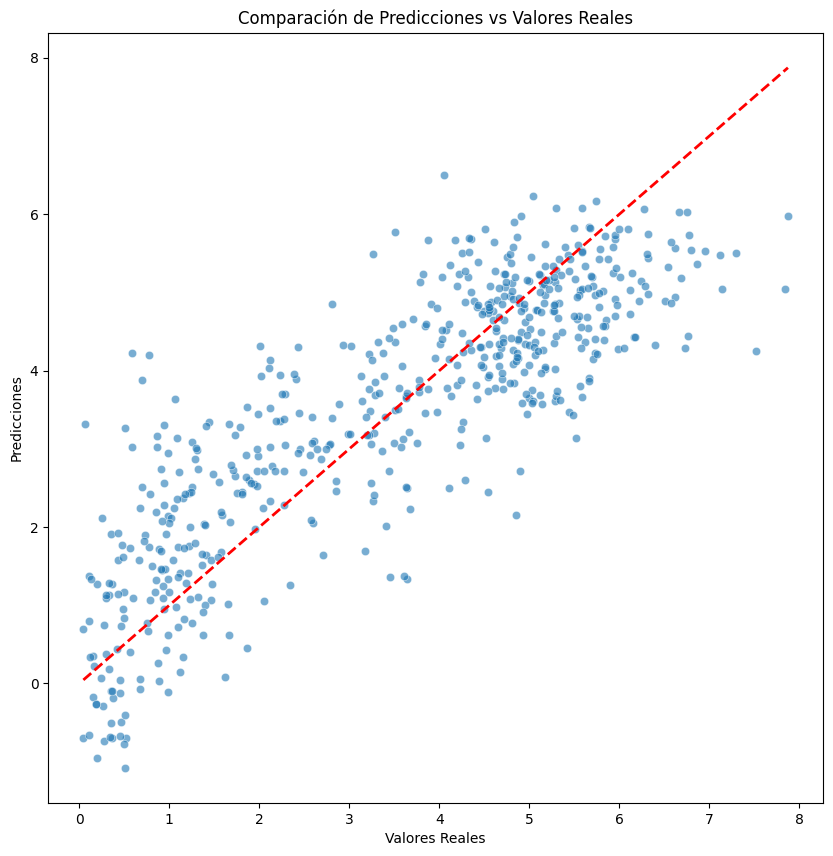

In [296]:
# Crear el gráfico de dispersión
plt.figure(figsize=(10, 10))
sns.scatterplot(x=y_train, y=y_pred, alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Comparación de Predicciones vs Valores Reales')
plt.show()

Para test

In [297]:
y_pred = lin_reg.predict(X_test_scaled)

argumentos = (y_test, y_pred)

print('MSE:', metrics.mean_squared_error(*argumentos))
print('RMSE:', np.sqrt(metrics.mean_squared_error(*argumentos)))
print('MAE:', metrics.mean_absolute_error(*argumentos))
print('MAPE:', metrics.mean_absolute_percentage_error(*argumentos))
print('R2:', lin_reg.score(X_test_scaled, y_test))

MSE: 1.0335692202952331
RMSE: 1.0166460644173236
MAE: 0.817088138298567
MAPE: 0.4787137492427603
R2: 0.7243821966369204


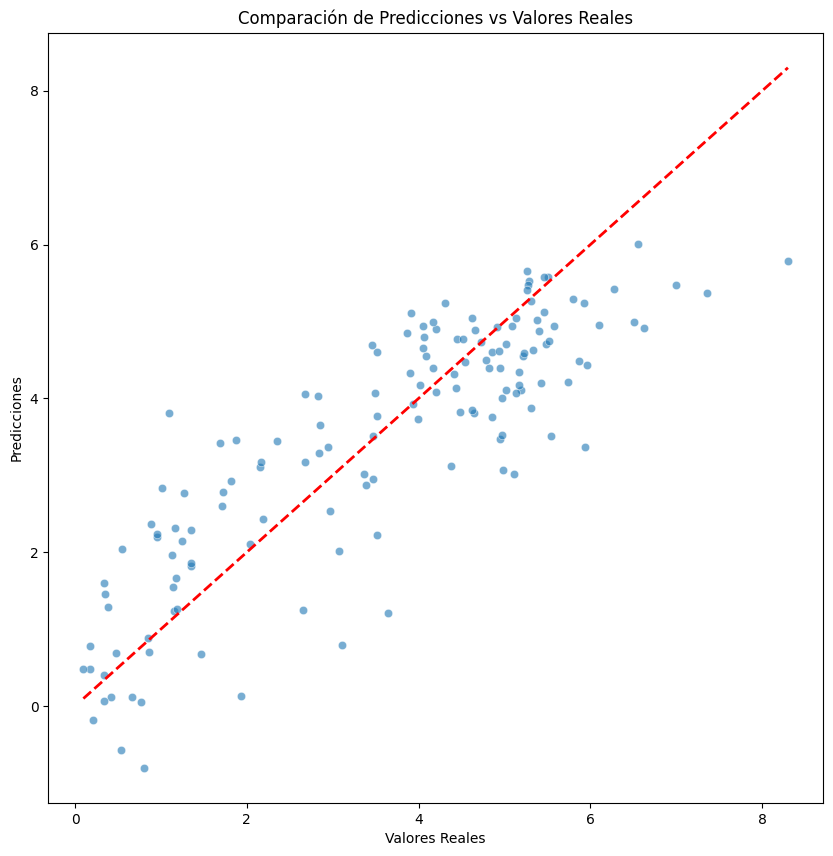

In [298]:
# Crear el gráfico de dispersión
plt.figure(figsize=(10, 10))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Comparación de Predicciones vs Valores Reales')
plt.show()

In [299]:
# Variable para contar cuántos valores de y_pred están dentro del 15% de y_test
count = 0

# Iterar a través de los elementos de y_test y y_pred
for y_t, y_p in zip(y_test, y_pred):
    if abs(y_p - y_t) <= 1:
        count += 1

print(f"Cantidad de valores de y_pred dentro del 15% de y_test: {count}")

Cantidad de valores de y_pred dentro del 15% de y_test: 96


In [300]:
len(y_test)

146

In [301]:
count/len(y_test)

0.6575342465753424

#### Elastic net

MSE: 1.1817909200475154
RMSE: 1.087102074346064
MAE: 0.8782935782256325
MAPE: 0.559880868339685
R2: 0.6848565040231285


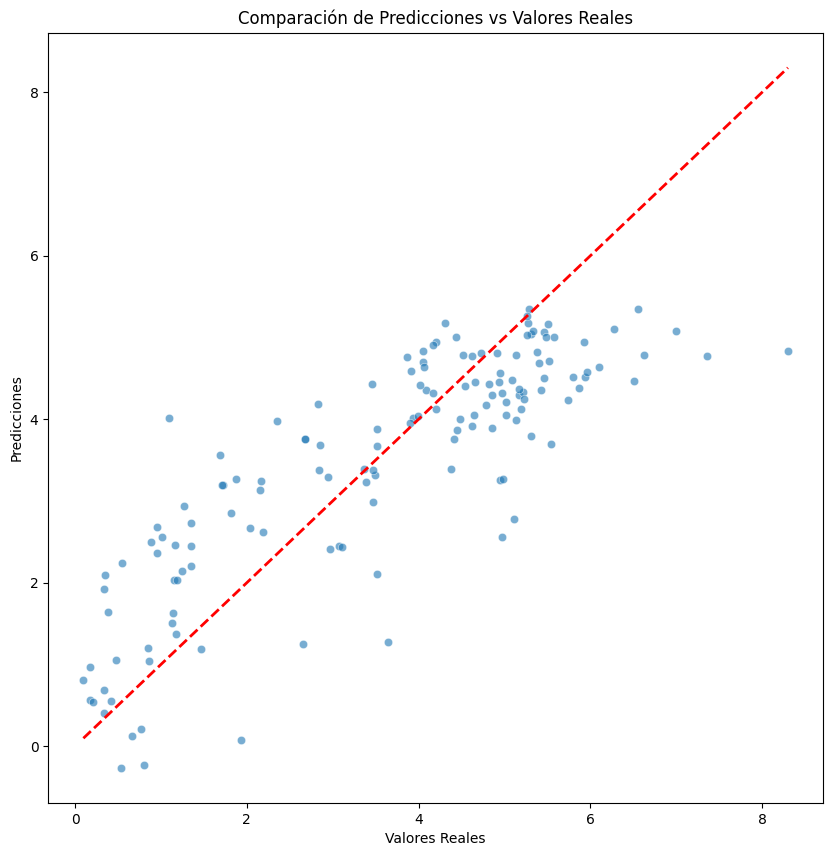

In [302]:
from sklearn.linear_model import ElasticNet

elastic_reg = ElasticNet(alpha= 0.2, l1_ratio= 0.1)
elastic_reg.fit(X_train_scaled,y_train)
y_pred = elastic_reg.predict(X_test_scaled)

argumentos = (y_test, y_pred)

print('MSE:', metrics.mean_squared_error(*argumentos))
print('RMSE:', np.sqrt(metrics.mean_squared_error(*argumentos)))
print('MAE:', metrics.mean_absolute_error(*argumentos))
print('MAPE:', metrics.mean_absolute_percentage_error(*argumentos))
print('R2:', elastic_reg.score(X_test_scaled, y_test))

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 10))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Comparación de Predicciones vs Valores Reales')
plt.show()

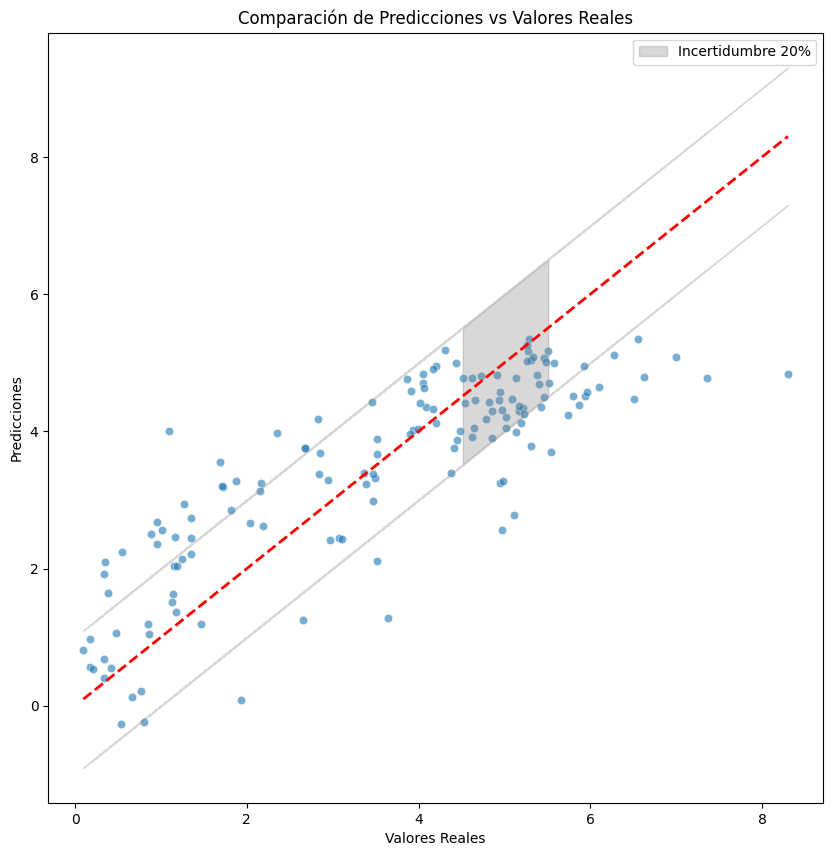

In [303]:
# Suponiendo que ya tienes y_test y y_pred definidos
plt.figure(figsize=(10, 10))

# Gráfico de dispersión
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)

# Línea diagonal (y = x)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

# Calcular el 20% de incertidumbre
uncertainty = 1

# Área sombreada (más y menos 20% de incertidumbre)
plt.fill_between(y_test, y_test - uncertainty, y_test + uncertainty, color='gray', alpha=0.3, label='Incertidumbre 20%')

# Etiquetas y título
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Comparación de Predicciones vs Valores Reales')

# Leyenda
plt.legend()

# Mostrar gráfico
plt.show()


### Probar varios modelos. Comparación con Validación Cruzada (pre-optimización)

In [304]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

model_names = ["Regresion Lineal","Random Forest","XGBoost","LightGBM","CatBoost"]

lr = LinearRegression()
rf = RandomForestRegressor(random_state= 42)
xgb = XGBRegressor(random_state = 42)
lgb = LGBMRegressor(random_state= 42, verbose = -100)
cat  = CatBoostRegressor(random_state= 42, verbose = False)


model_set = [lr, rf, xgb, lgb, cat]

In [305]:
from sklearn.model_selection import cross_val_score

metricas_cv = {}
valores = []
for nombre,modelo in zip(model_names, model_set):
    print(modelo)
    if nombre == "Regresion Lineal":
        metricas_cv[nombre] = cross_val_score(modelo, X_train_scaled, y_train, cv = 3, scoring = "neg_mean_absolute_percentage_error")
    else:
        metricas_cv[nombre] = cross_val_score(modelo, X_train, y_train, cv = 3, scoring = "neg_mean_absolute_percentage_error")
    valores.append(np.mean(metricas_cv[nombre]))
ganador = list(metricas_cv.keys())[np.argmax(valores)]

LinearRegression()
RandomForestRegressor(random_state=42)
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)
LGBMRegressor(random_state=42, verbose=-100)


KeyboardInterrupt: 

In [ ]:
for model_name, valores in metricas_cv.items():
    print(f"Model <{model_name}>, MAPE: {(-np.mean(valores))}")
print(f"El ganador es {ganador}")

Model <Regresion Lineal>, MAPE: 0.7179747010478499
Model <Random Forest>, MAPE: 0.6010650448537905
Model <XGBoost>, MAPE: 0.5820596439458944
Model <LightGBM>, MAPE: 0.5780806215360198
Model <CatBoost>, MAPE: 0.5855710620183644
El ganador es LightGBM


In [ ]:
'''for model_name, valores in metricas_cv.items():
    print(f"Model <{model_name}>, RMSE_CV: {np.sqrt(-np.mean(valores))}")
print(f"El ganador es {ganador}")'''

'for model_name, valores in metricas_cv.items():\n    print(f"Model <{model_name}>, RMSE_CV: {np.sqrt(-np.mean(valores))}")\nprint(f"El ganador es {ganador}")'

### Optimizacion del modelo ganador


In [ ]:
from sklearn.model_selection import GridSearchCV

params_grid = {
    "n_estimators": [50,100,200,400], # 100 es el valor por defecto 
    "max_depth": [5,10,15,None], # None es el valor por defecto
    "min_samples_leaf": [5,10,15], # 1 es el valor por defecto. Pero sobreajustaria mucho el modelo
    'min_samples_split': [2,5,10], # 2 es el valor por defecto    
    "max_features": ["sqrt","log2",None], # 1.0 (ó None) es el valor por defecto
    "max_samples": [0.3,0.6,1.0] # 1.0 (ó None) es el valor por defecto
}

rf_grid = GridSearchCV(rf,
                       param_grid= params_grid,
                       cv = 5,
                       scoring = "neg_root_mean_squared_error",
                       n_jobs = -1)

rf_grid.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
-rf_grid.best_score_

In [ ]:
rf_grid.best_params_

In [ ]:
y_pred = rf_grid.best_estimator_.predict(X_test)
y_pred = pd.Series(y_pred, index=X_test.index, name='Predictions')

argumentos = (y_test, y_pred)

print('MSE:', metrics.mean_squared_error(*argumentos))
print('RMSE:', np.sqrt(metrics.mean_squared_error(*argumentos)))
print('MAE:', metrics.mean_absolute_error(*argumentos))
print('MAPE:', metrics.mean_absolute_percentage_error(*argumentos))
print('R2:', rf_grid.best_estimator_.score(X_test, y_test))

In [ ]:
df_res = pd.DataFrame(y_test)

In [ ]:
df_res['pred'] = y_pred

In [ ]:
df_res['Class'] = test_set['IGBP_class']

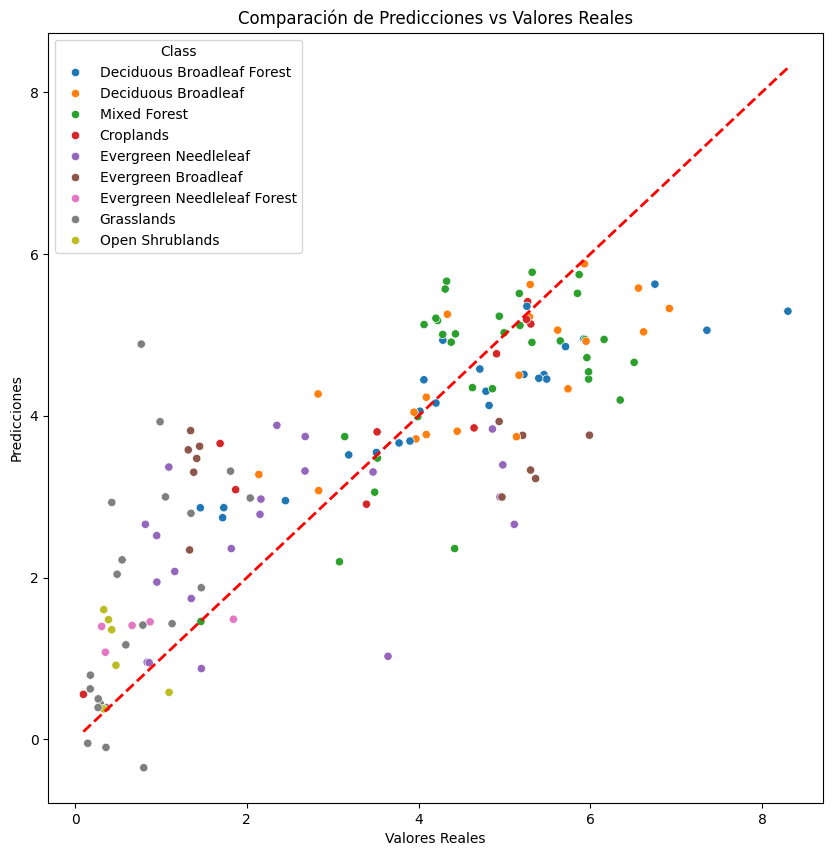

In [ ]:
plt.figure(figsize=(10, 10))

sns.scatterplot(data=df_res, x="LAI_Warren", y="pred", hue="Class")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Comparación de Predicciones vs Valores Reales')
plt.show()


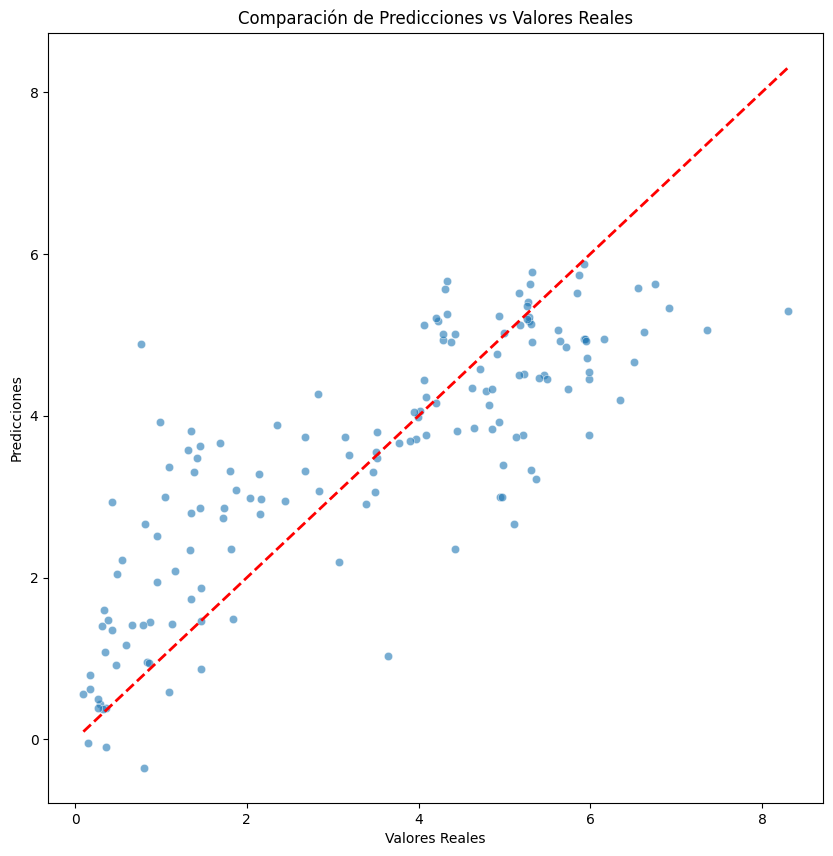

In [ ]:
# Crear el gráfico de dispersión
plt.figure(figsize=(10, 10))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Comparación de Predicciones vs Valores Reales')
plt.show()

### Analisis de errores

Calculamos los residuos y vemos la distribución de esos errores.

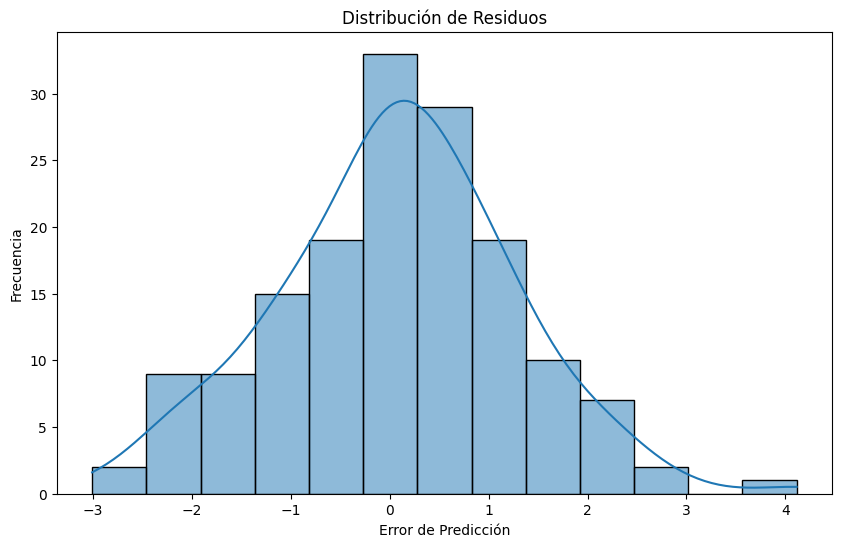

In [ ]:
# Calcular residuos
residuos = y_pred - y_test

# Visualización de residuos
plt.figure(figsize=(10, 6))
sns.histplot(residuos, kde=True)
plt.title('Distribución de Residuos')
plt.xlabel('Error de Predicción')
plt.ylabel('Frecuencia')
plt.show()

Graficamos los residuos según el valor real para intentar ver patrones donde se concentran los errores.

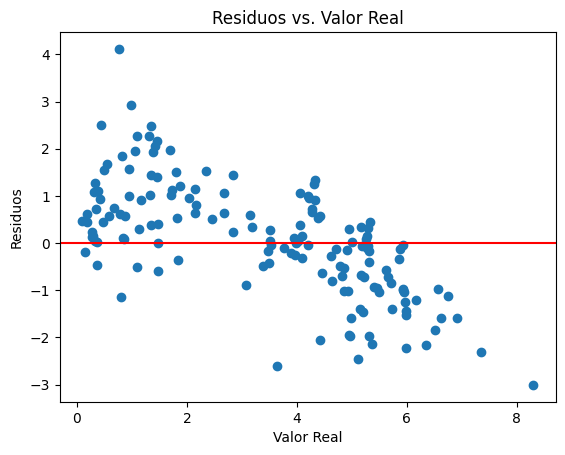

In [ ]:
# Gráfica de dispersión de residuos
plt.scatter(y_test, residuos)
plt.title('Residuos vs. Valor Real')
plt.xlabel('Valor Real')
plt.ylabel('Residuos')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()


In [ ]:
residuos

204    0.382599
731   -0.052238
374   -2.060367
487   -0.640506
102    1.216558
         ...   
473   -0.358359
740    1.135222
4      0.723474
293    1.839743
8      1.256146
Name: LAI_Warren, Length: 155, dtype: float64

In [ ]:
test_set.columns

Index(['id', 'longitude', 'latitude', 'time', 'B2', 'B3', 'B4', 'B5', 'B6',
       'B7', 'B8', 'B8A', 'B11', 'B12', 'SCL', 'QA60', 'Site_sat', 'GBOV_ID',
       'Site', 'GROUND_DATA_PI', 'GROUND_DATA_PIs_Email', 'GBOV_Email',
       'Network', 'Elevation', 'IGBP_class', 'Lat_IS', 'Lon_IS', 'TIME_IS',
       'Version', 'up_flag', 'down_flag', 'LAI_Miller_up', 'LAI_Warren_up',
       'LAIe_Miller_up', 'LAIe_Warren_up', 'LAI_Miller_down',
       'LAI_Warren_down', 'LAIe_Miller_down', 'LAIe_Warren_down',
       'LAI_Miller_up_err', 'LAI_Warren_up_err', 'LAIe_Miller_up_err',
       'LAIe_Warren_up_err', 'clumping_Miller_up', 'clumping_Warren_up',
       'LAI_Miller_down_err', 'LAI_Warren_down_err', 'LAIe_Miller_down_err',
       'LAIe_Warren_down_err', 'clumping_Miller_down', 'clumping_Warren_down',
       'clumping_Miller_up_err', 'clumping_Warren_up_err',
       'clumping_Miller_down_err', 'clumping_Warren_down_err',
       'Warren_up_flag', 'Warren_down_flag', 'LAI_Warren', 'LAI_Warren_e

In [ ]:
test_set['LAIe_Warren'] = test_set['LAIe_Warren_up'].astype(float) + test_set['LAIe_Warren_down'].astype(float)

In [ ]:
test_set[abs(residuos) >= 2][['time','TIME_IS','delta','Site','IGBP_class','LAI_Warren','LAIe_Warren','LAI_Warren_down', 'LAI_Warren_err','LAIe_Warren_up','clumping_Warren_up','clumping_Warren_down','clumping_Warren_up_err','clumping_Warren_down_err']]

,time,TIME_IS,delta,Site,IGBP_class,LAI_Warren,LAIe_Warren,LAI_Warren_down,LAI_Warren_err,LAIe_Warren_up,clumping_Warren_up,clumping_Warren_down,clumping_Warren_up_err,clumping_Warren_down_err
374,2019-09-26 16:12:25.225,2019-09-26 10:50:00,0 days 05:22:25.225000,Smithsonian Conservation Biology Institute,Mixed Forest,4.420000,2.770000,1.050000,0.380000,2.010000,0.600000,0.720000,0.050000,0.170000
539,2022-05-22 16:44:30.923,2022-05-25 06:52:00,2 days 14:07:29.077000,Talladega National Forest,Evergreen Needleleaf,5.114683,3.567550,0.783337,0.231975,2.934541,0.677513,0.808092,0.036629,0.124751
225,2019-08-20 18:02:57.951,2019-08-21 06:10:00,0 days 12:07:02.049000,Niwot Ridge Mountain Research Station,Evergreen Needleleaf,3.644000,2.278000,0.354000,0.202000,1.940000,0.590000,0.950000,0.040000,0.120000
328,2020-01-18 20:59:57.294,2020-01-16 11:39:00,2 days 09:20:57.294000,Pu u Maka ala Natural Area Reserve,Evergreen Broadleaf,5.362604,3.746970,0.794519,0.260399,3.141065,0.687611,0.762607,0.041609,0.130487
165,2022-03-23 15:07:51.766,2022-03-23 11:33:00,0 days 03:34:51.766000,Lajas Experimental Station,Grasslands,0.427854,NaN,0.427854,0.026374,NaN,NaN,0.957100,NaN,0.082323
551,2018-06-01 17:12:55.191,2018-05-30 20:19:00,1 days 20:53:55.191000,University of Kansas Field Site,Deciduous Broadleaf Forest,8.300687,5.685165,4.674995,0.409225,2.454330,0.676927,0.691088,0.040597,0.061076
325,2019-11-09 21:00:05.961,2019-11-06 11:27:00,3 days 09:33:05.961000,Pu u Maka ala Natural Area Reserve,Evergreen Broadleaf,1.416821,0.841820,0.198635,0.236075,0.666664,0.547260,0.881794,0.125489,0.214776
367,2022-11-18 21:00:03.203,2022-11-17 13:17:00,1 days 07:43:03.203000,Pu u Maka ala Natural Area Reserve,Evergreen Broadleaf,1.450455,0.754929,0.181772,0.310175,0.593560,0.467855,0.887756,0.150553,0.206981
357,2022-02-01 20:59:57.739,2022-01-31 14:21:00,1 days 06:38:57.739000,Pu u Maka ala Natural Area Reserve,Evergreen Broadleaf,1.345873,0.796288,0.182359,0.219631,0.643949,0.553452,0.835381,0.126959,0.210660
398,2022-09-15 16:12:28.805,2022-09-14 04:27:00,1 days 11:45:28.805000,Smithsonian Conservation Biology Institute,Mixed Forest,6.347663,3.920265,2.458432,0.469629,2.379482,0.611813,0.626734,0.037027,0.110801


<Axes: xlabel='LAI_Warren_err', ylabel='Count'>

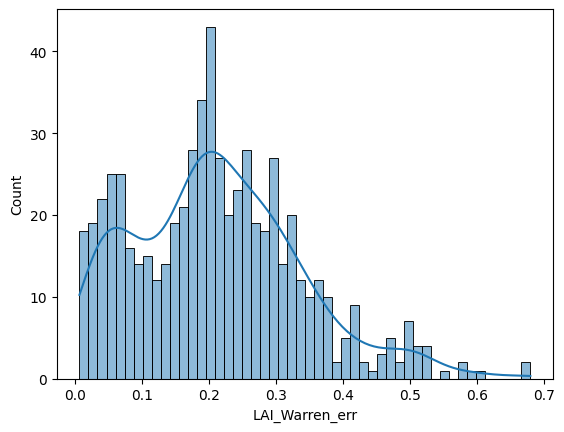

In [ ]:
sns.histplot(train_set['LAI_Warren_err'], kde=True, bins=50)

<Axes: xlabel='clumping_Warren_up_err', ylabel='Count'>

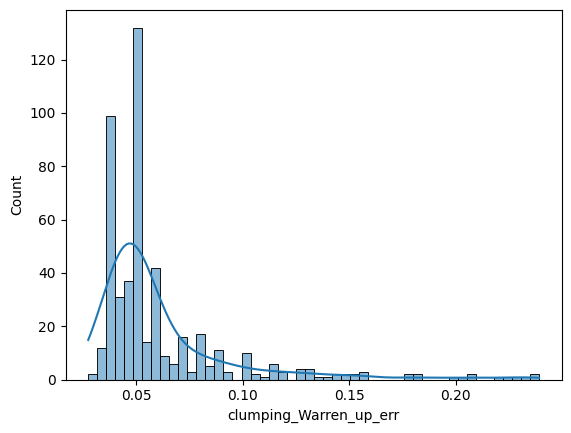

In [ ]:
sns.histplot(train_set['clumping_Warren_up_err'], kde=True, bins=50)

<Axes: xlabel='clumping_Warren_down_err', ylabel='Count'>

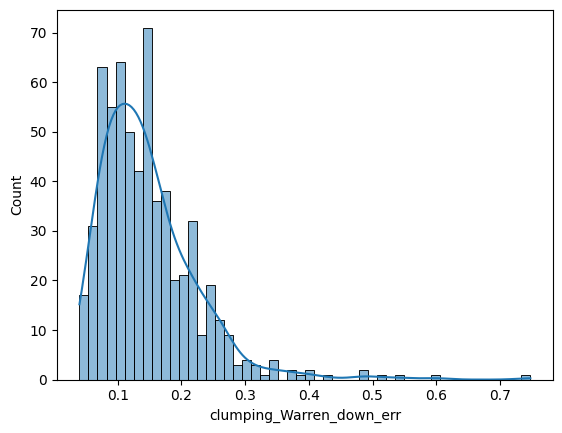

In [ ]:
sns.histplot(train_set['clumping_Warren_down_err'], kde=True, bins=50)

In [ ]:
test_set.IGBP_class.value_counts()

IGBP_class
Mixed Forest                   34
Deciduous Broadleaf Forest     25
Grasslands                     22
Evergreen Needleleaf           21
Deciduous Broadleaf            20
Evergreen Broadleaf            12
Croplands                      10
Open Shrublands                 6
Evergreen Needleleaf Forest     5
Name: count, dtype: int64

In [ ]:
train_set.IGBP_class.value_counts()

IGBP_class
Mixed Forest                   134
Deciduous Broadleaf Forest      97
Grasslands                      88
Evergreen Needleleaf            86
Deciduous Broadleaf             81
Evergreen Broadleaf             47
Croplands                       38
Open Shrublands                 23
Evergreen Needleleaf Forest     22
Name: count, dtype: int64

In [ ]:
df_cross['date_sat'] = pd.to_datetime(df_cross['date_sat'])

In [ ]:
test_set['IGBP_class'].value_counts()

IGBP_class
Mixed Forest                   34
Deciduous Broadleaf Forest     25
Grasslands                     22
Evergreen Needleleaf           21
Deciduous Broadleaf            20
Evergreen Broadleaf            12
Croplands                      10
Open Shrublands                 6
Evergreen Needleleaf Forest     5
Name: count, dtype: int64

<Axes: xlabel='IGBP_class', ylabel='Count'>

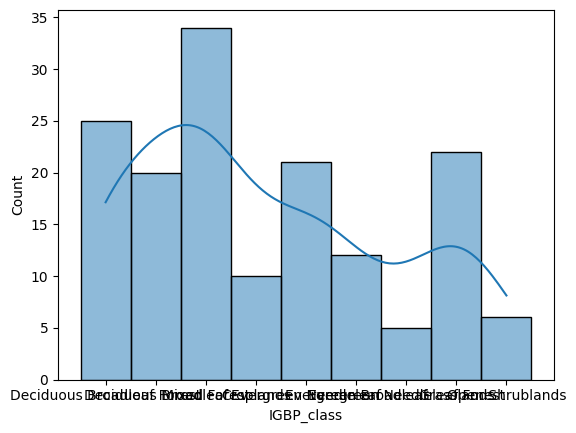

In [ ]:

sns.histplot(test_set['IGBP_class'], kde=True)

<Axes: xlabel='date_sat', ylabel='Count'>

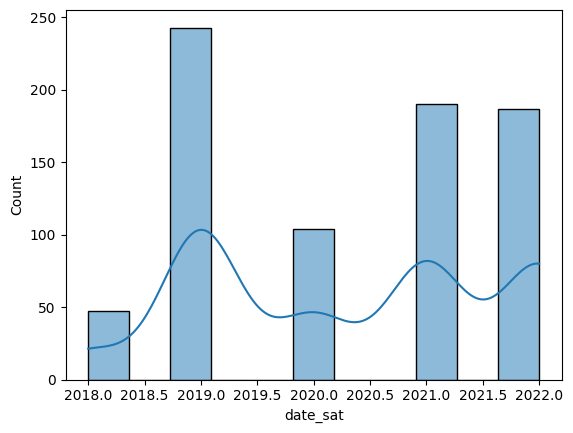

In [ ]:
sns.histplot(df_cross['date_sat'].dt.year, kde=True)